---
title: Linear Shallow Water Model
subject: Jax Approximate Ocean Models
# subtitle: How can I estimate the state AND the parameters?
short_title: Linear SWM (Field API)
authors:
  - name: J. Emmanuel Johnson
    affiliations:
      - CNRS
      - MEOM
    orcid: 0000-0002-6739-0053
    email: jemanjohnson34@gmail.com
  - name: Takaya Uchida
    affiliations:
      - FSU
    orcid: https://orcid.org/0000-0002-8654-6009
    email: tuchida@fsu.edu
license: CC-BY-4.0
keywords: jax, shallow water model, differentiable
abbreviations:
    SW: Shallow Water
    QG: Quasi-Geostrophic
    PDE: Partial Differential Equation
    RHS: Right Hand Side
---

In [7]:
import autoroot
import jax
import jax.numpy as jnp
import numpy as np
import equinox as eqx
import kernex as kex
import finitediffx as fdx
import diffrax as dfx
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import typing as tp
from tqdm.notebook import tqdm, trange
from jaxtyping import Float, Array, PyTree, ArrayLike
import pandas as pd
from jaxsw._src.domain.base import Domain
from jaxsw._src.fields.base import Field
from jaxsw._src.models.pde import DynamicalSystem
from jaxsw._src.domain.time import TimeDomain
from jaxsw._src.operators.functional import grid as F_grid
from jaxsw._src.operators.fd import Difference

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)
jax.config.update("jax_enable_x64", True)

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Formulation

$$
\begin{aligned}
\frac{\partial h}{\partial t} &+ H
\left(\frac{\partial u}{\partial x} + \frac{\partial v}{\partial y} \right) = 0 \\
\frac{\partial u}{\partial t} &- fv =
- g \frac{\partial h}{\partial x}
- \kappa u \\
\frac{\partial v}{\partial t} &+ fu =
- g \frac{\partial h}{\partial y}
- \kappa v
\end{aligned}
$$ (eq:sw_linear)

## Domain



In [2]:
dx = dy = 20e3
Lx = 100 * dx
Ly = 101 * dy

ncols = 5

# initialize the h domain
h_domain = Domain(xmin=(0, 0), xmax=(Lx, Ly), dx=(dx, dy))

# initialize the u-velocity domain
u_domain = Domain(xmin=(0, 0), xmax=(Lx, Ly), dx=(dx, dy), stagger=("right", None))

# initialize the v-velocity domain
v_domain = Domain(xmin=(0, 0), xmax=(Lx, Ly), dx=(dx, dy), stagger=(None, "right"))


print(f"Nx: {h_domain.Nx}")
print(f"Lx: {h_domain.Lx}")
print(f"dx: {h_domain.dx}")
print(f"Size: {h_domain.size}")
print(f"nDims: {h_domain.ndim}")
print(f"Grid Size: {h_domain.grid.shape}")
print(f"Cell Volume: {h_domain.cell_volume:_}")

Nx: (101, 102)
Lx: (2000000.0, 2020000.0)
dx: (20000.0, 20000.0)
Size: (101, 102)
nDims: 2
Grid Size: (101, 102, 2)
Cell Volume: 400_000_000.0


## Initial Condition

```python

# grid setup
x, y = (
    np.arange(n_x) * dx,
    np.arange(n_y) * dy
)
Y, X = np.meshgrid(y, x, indexing='ij')
# initial conditions
h0 = depth + 1.0 * np.exp(
    - (X - x[n_x // 2]) ** 2 / rossby_radius ** 2
    - (Y - y[n_y - 2]) ** 2 / rossby_radius ** 2
)
u0 = np.zeros_like(h0)
v0 = np.zeros_like(h0)
```

In [3]:
from jaxtyping import Array


class State(tp.NamedTuple):
    u: Field
    v: Field
    h: Field

    @classmethod
    def init_state(cls, params):
        h = Field(init_h0(h_domain, params), h_domain)
        v = Field(jnp.zeros_like(h.values), v_domain)
        u = Field(jnp.zeros_like(h.values), u_domain)

        return cls(u=u, v=v, h=h)


class Params(tp.NamedTuple):
    depth: float
    gravity: float
    coriolis: float  # of ARRAY

    @property
    def rossby_radius(self):
        return np.sqrt(self.gravity * self.depth) / self.coriolis


def init_h0(domain, params):
    """A LOT of work for a lil Gauss bump!"""

    X = domain.grid[..., 0]
    Y = domain.grid[..., 1]

    x_center = domain.coords[0][domain.Nx[0] // 2]
    y_center = domain.coords[1][domain.Nx[1] - 2]

    h0 = params.depth + 1.0 * np.exp(
        -((X - x_center) ** 2) / params.rossby_radius**2
        - (Y - y_center) ** 2 / params.rossby_radius**2
    )

    return jnp.asarray(h0)


params = Params(depth=100.0, gravity=9.81, coriolis=2e-4)

state_init = State.init_state(params)

In [4]:
state_init

State(u=Field(
  values=f64[101,102],
  domain=Domain(
    xmin=(10000.0, 0.0),
    xmax=(2010000.0, 2020000.0),
    dx=(20000.0, 20000.0)
  )
), v=Field(
  values=f64[101,102],
  domain=Domain(
    xmin=(0.0, 10000.0),
    xmax=(2000000.0, 2030000.0),
    dx=(20000.0, 20000.0)
  )
), h=Field(
  values=f64[101,102],
  domain=Domain(
    xmin=(0.0, 0.0),
    xmax=(2000000.0, 2020000.0),
    dx=(20000.0, 20000.0)
  )
))

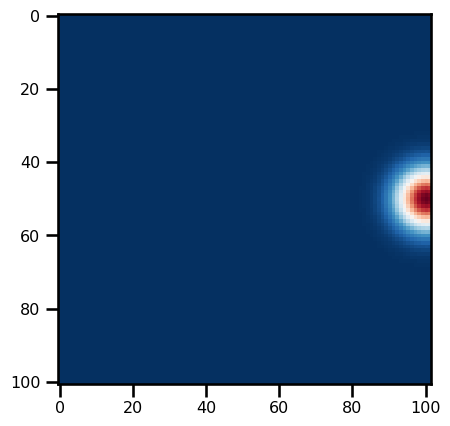

In [5]:
plt.imshow(state_init.h.values, cmap="RdBu_r")

## Boundary Conditions

In [4]:
from jaxsw._src.operators.custom import FuncOperator

In [7]:
FuncOperator??

Init signature: FuncOperator(*args, **kwargs)
Docstring:      FuncOperator(*args, **kwargs)
Source:        
class FuncOperator(eqx.Module):
    f: Callable = eqx.static_field()

    def __init__(self, f):
        self.f = f

    def __call__(self, u: Field) -> Field:
        u = eqx.tree_at(lambda x: x.values, u, self.f(u.values))

        return u
File:           ~/code_projects/jaxsw/jaxsw/_src/operators/custom.py
Type:           _ModuleMeta
Subclasses:     

In [5]:
def bc_u(u: Array):
    u = u.at[-2, :].set(jnp.asarray(0.0))
    return u


def bc_v(v: Array):
    v = v.at[:, -2].set(jnp.asarray(0.0))
    return v

In [6]:
bc_u_op = FuncOperator(bc_u)
bc_v_op = FuncOperator(bc_v)
u_bc = bc_u_op(state_init.u)
u_bc

Field(
  values=f64[101,102],
  domain=Domain(
    xmin=(10000.0, 0.0),
    xmax=(2010000.0, 2020000.0),
    dx=(20000.0, 20000.0)
  )
)

## Equation of Motion

In [16]:
class LinearShallowWater2D(DynamicalSystem):
    @staticmethod
    def equation_of_motion(t: float, state: State, args):
        """2D Linear Shallow Water Equations

        Equation:
            ∂h/∂t + H (∂u/∂x + ∂v/∂y) = 0
            ∂u/∂t - fv = - g ∂h/∂x - ku
            ∂v/∂t + fu = - g ∂h/∂y - kv
        """
        # unpack state
        u, v, h = state.u, state.v, state.h

        # unpack params
        depth, coriolis, gravity = (
            args.depth,
            args.coriolis,
            args.gravity,
        )

        # # Apply Boundary Conditions
        u = bc_u_op(u)
        v = bc_v_op(v)

        ################
        # H COMPONENT
        # ∂h/∂t = - H (∂u/∂x + ∂v/∂y)
        ################
        h_rhs = jnp.zeros_like(h.values)

        # create them on the fly
        du_dx = Difference(method="backward")(u, axis=0)
        dv_dy = Difference(method="backward")(v, axis=1)

        h_rhs = h_rhs.at[1:-1, 1:-1].set(
            -depth * (du_dx.values[1:-1, 1:-1] + dv_dy.values[1:-1, 1:-1])
        )

        ################
        # U COMPONENT
        # ∂u/∂t = fv - g ∂h/∂x
        ################
        u_rhs = jnp.zeros_like(u.values)

        v_avg = F_grid.grid_operator(v, ("inner", "inner"))
        v_avg = v_avg.values[1:, :-1] * coriolis

        dh_dx = Difference(method="forward")(h, axis=0)
        dh_dx = -dh_dx.values * gravity

        u_rhs = u_rhs.at[1:-1, 1:-1].set(v_avg + dh_dx[1:-1, 1:-1])

        ################
        # V COMPONENT
        # ∂v/∂t = - fu - g ∂h/∂y
        ###############

        v_rhs = jnp.zeros_like(v.values)

        u_avg = F_grid.grid_operator(u, ("inner", "inner"))
        u_avg = -u_avg.values[:-1, 1:] * coriolis

        dh_dy = Difference(method="forward")(h, axis=1)
        dh_dy = -dh_dy.values * gravity

        v_rhs = v_rhs.at[1:-1, 1:-1].set(u_avg + dh_dy[1:-1, 1:-1])

        # update state
        state = eqx.tree_at(lambda x: x.u.values, state, u_rhs)
        state = eqx.tree_at(lambda x: x.v.values, state, v_rhs)
        state = eqx.tree_at(lambda x: x.h.values, state, h_rhs)
        return state

In [17]:
state_update = LinearShallowWater2D.equation_of_motion(0, state_init, params)

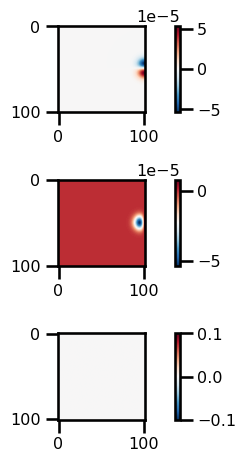

In [18]:
fig, ax = plt.subplots(nrows=3)
pts = ax[0].imshow(state_update.u.values, cmap="RdBu_r")
plt.colorbar(pts)
pts = ax[1].imshow(state_update.v.values, cmap="RdBu_r")
plt.colorbar(pts)
pts = ax[2].imshow(state_update.h.values, cmap="RdBu_r")
plt.colorbar(pts)
plt.tight_layout()

## Time Stepping

In [19]:
# TEMPORAL DISCRETIZATION
# initialize temporal domain

dt = 0.25 * state_init.h.domain.dx[0] / np.sqrt(params.gravity * params.depth)
print(f"Step Size (dt): {dt:.4e}")

tmin = 0.0
tmax = pd.to_timedelta(5, unit="days").total_seconds()
num_save = 60

Step Size (dt): 1.5964e+02


In [20]:
import pandas as pd

In [21]:
t_domain = TimeDomain(tmin=tmin, tmax=tmax, dt=dt)
ts = jnp.linspace(tmin, tmax, num_save)
saveat = dfx.SaveAt(ts=ts)

# DYNAMICAL SYSTEM
dyn_model = LinearShallowWater2D(t_domain=t_domain, saveat=saveat)

### Integration

In [22]:
# Euler, Constant StepSize
solver = dfx.Dopri5()

# Tolerances
stepsize_controller = dfx.ConstantStepSize()
# rtol = 1e-3
# atol = 1e-4
# stepsize_controller = dfx.PIDController(
#     pcoeff=0.3, icoeff=0.4, rtol=rtol, atol=atol, dtmax=dt
# )

# SPATIAL DISCRETIZATION
params_init = Params(depth=100.0, gravity=9.81, coriolis=2e-4)
state_init = State.init_state(params_init)


# integration
sol = dfx.diffeqsolve(
    terms=dfx.ODETerm(dyn_model.equation_of_motion),
    solver=solver,
    t0=ts.min(),
    t1=ts.max(),
    dt0=dt,
    y0=state_init,
    saveat=saveat,
    args=params_init,
    stepsize_controller=stepsize_controller,
    max_steps=None,
)

In [23]:
sol.ys

State(u=Field(
  values=f64[60,101,102],
  domain=Domain(
    xmin=(10000.0, 0.0),
    xmax=(2010000.0, 2020000.0),
    dx=(20000.0, 20000.0)
  )
), v=Field(
  values=f64[60,101,102],
  domain=Domain(
    xmin=(0.0, 10000.0),
    xmax=(2000000.0, 2030000.0),
    dx=(20000.0, 20000.0)
  )
), h=Field(
  values=f64[60,101,102],
  domain=Domain(
    xmin=(0.0, 0.0),
    xmax=(2000000.0, 2020000.0),
    dx=(20000.0, 20000.0)
  )
))

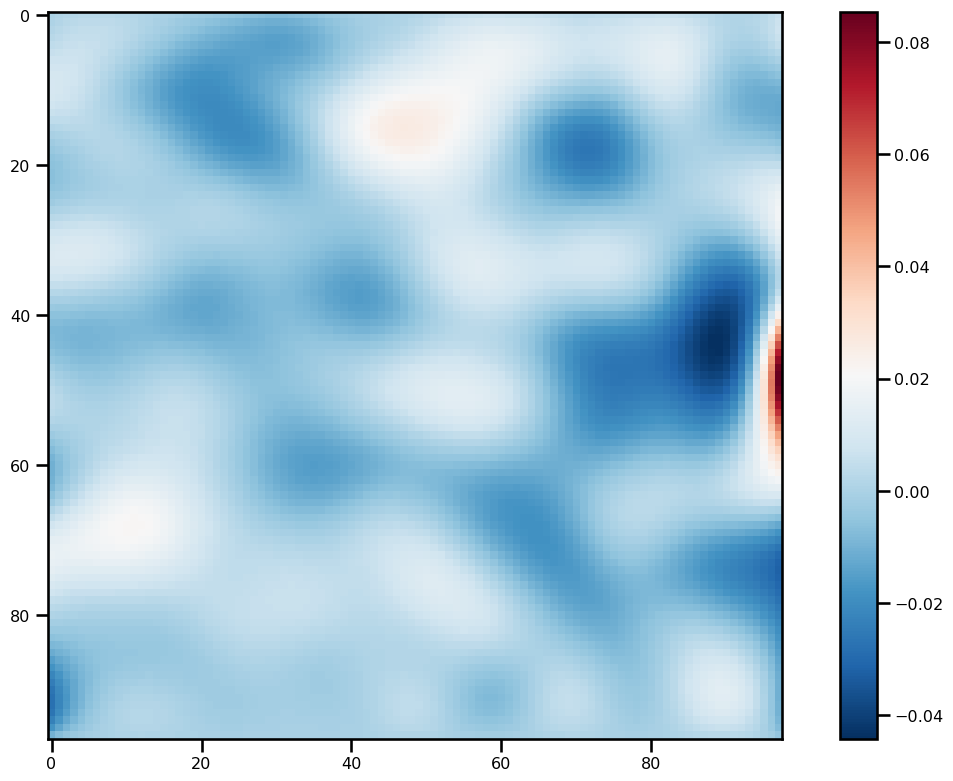

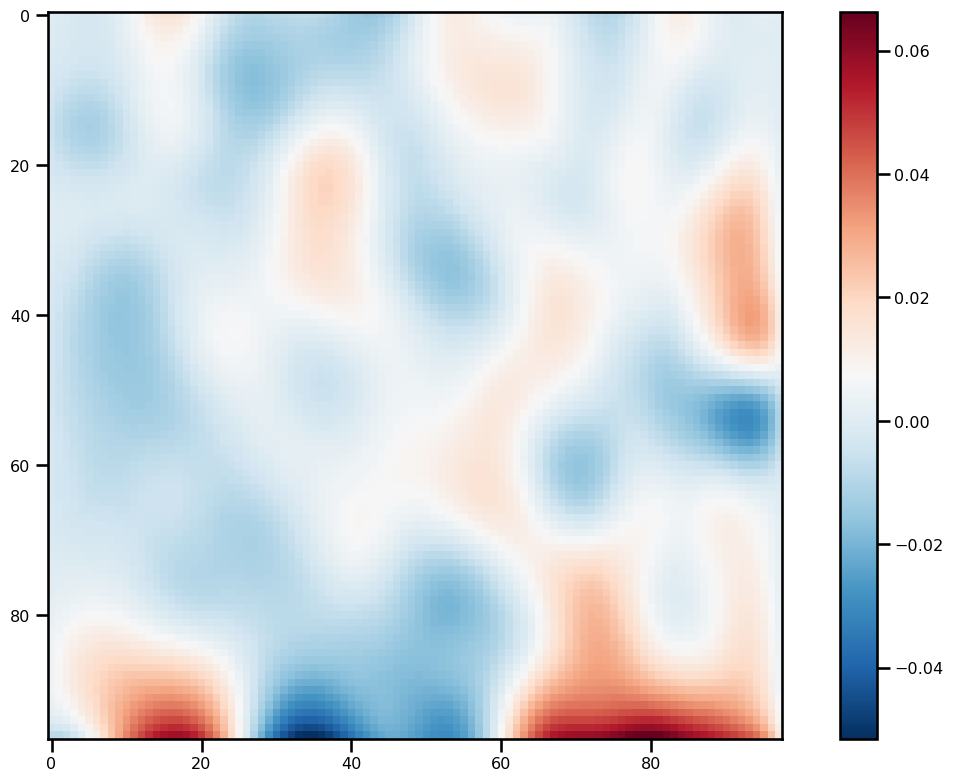

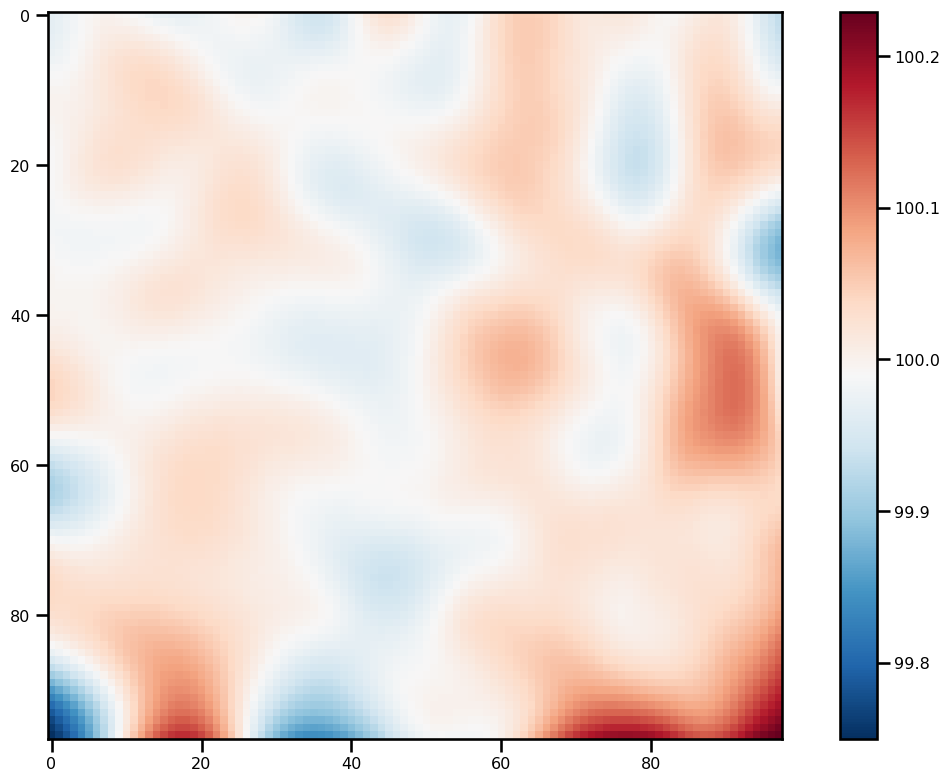

In [24]:
for ivar in sol.ys:
    # print(ivar[-1])
    fig, ax = plt.subplots(figsize=(12, 8))
    pts = ax.imshow(ivar.values[-1][2:-2, 2:-2], cmap="RdBu_r")
    plt.colorbar(pts)
    plt.tight_layout()

## Analysis

In [25]:
ds_results = xr.Dataset(
    data_vars={
        "u": (("time", "x", "y"), sol.ys.u.values),
        "v": (("time", "x", "y"), sol.ys.v.values),
        "h": (("time", "x", "y"), sol.ys.h.values),
    },
    coords={
        "time": (("time"), sol.ts),
        "x": (("x"), state_init.h.domain.coords[0]),
        "y": (("y"), state_init.h.domain.coords[1]),
    },
)
ds_results

<xarray.Dataset>
Dimensions:  (time: 60, x: 101, y: 102)
Coordinates:
  * time     (time) float64 0.0 7.322e+03 1.464e+04 ... 4.247e+05 4.32e+05
  * x        (x) float64 0.0 2e+04 4e+04 6e+04 ... 1.96e+06 1.98e+06 2e+06
  * y        (y) float64 0.0 2e+04 4e+04 6e+04 ... 1.98e+06 2e+06 2.02e+06
Data variables:
    u        (time, x, y) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    v        (time, x, y) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    h        (time, x, y) float64 100.0 100.0 100.0 100.0 ... 100.0 100.0 100.0

In [26]:
from xmovie import Movie
from pathlib import Path
from matplotlib import ticker


def custom_plot_p_layers(ds, fig, tt, *args, **kwargs):
    sub = ds.isel(time=tt)
    time = sub.v.time.values / 86400

    xlim = kwargs.pop("xlim", None)
    ylim = kwargs.pop("ylim", None)
    vmin = kwargs.pop("vmin", sub.h.isel(x=slice(1, -1), y=slice(1, -1)).min())
    vmax = kwargs.pop("vmax", sub.h.isel(x=slice(1, -1), y=slice(1, -1)).max())
    cmap = kwargs.pop("cmap", "viridis")

    fig.set_size_inches(15, 4.5)

    ax = fig.subplots(
        ncols=3,
    )

    # HEIGHT
    cbar_kwargs = {"label": "Height [m]"}
    pts = sub.h.isel(x=slice(1, -1), y=slice(1, -1)).plot.pcolormesh(
        ax=ax[0],
        cmap="viridis",
        add_colorbar=True,
        vmin=vmin,
        vmax=vmax,
        cbar_kwargs=cbar_kwargs,
        # **kwargs
    )
    loc = ticker.MaxNLocator(6)
    levels = loc.tick_values(vmin, vmax)
    sub.h.isel(x=slice(1, -1), y=slice(1, -1)).plot.contour(
        ax=ax[0],
        levels=levels,
        vmin=vmin,
        vmax=vmax,
        alpha=0.5,
        linewidths=1,
        cmap="black",
        linestyles=np.where(levels >= 0, "-", "--"),
    )

    # ax.set_aspect('equal')
    pts = ax[0].set(xlabel="x [m]", ylabel="y [m]", title=f"Time: {time:.4f} day(s)")

    # U-VELOCITY
    cbar_kwargs = {"label": "U-Velocity [ms$^{-1}$]"}
    vmin = sub.u.isel(x=slice(1, -2), y=slice(1, -1)).min()
    vmax = sub.u.isel(x=slice(1, -2), y=slice(1, -1)).max()
    pts = sub.u.isel(x=slice(1, -2), y=slice(1, -1)).plot.pcolormesh(
        ax=ax[1],
        cmap="coolwarm",
        add_colorbar=True,
        vmin=vmin,
        vmax=vmax,
        cbar_kwargs=cbar_kwargs
        # **kwargs
    )
    loc = ticker.MaxNLocator(6)
    levels = loc.tick_values(vmin, vmax)
    sub.u.isel(x=slice(1, -2), y=slice(1, -1)).plot.contour(
        ax=ax[1],
        levels=levels,
        vmin=vmin,
        vmax=vmax,
        alpha=0.5,
        linewidths=1,
        cmap="black",
        linestyles=np.where(levels >= 0, "-", "--"),
    )

    # ax.set_aspect('equal')
    pts = ax[1].set(xlabel="x [m]", ylabel="y [m]", title=f"Time: {time:.4f} day(s)")

    # V-VELOCITY
    cbar_kwargs = {"label": "V-Velocity [ms$^{-1}$]"}
    vmin = sub.v.isel(x=slice(1, -1), y=slice(1, -2)).min()
    vmax = sub.v.isel(x=slice(1, -1), y=slice(1, -2)).max()
    pts = sub.v.isel(x=slice(1, -1), y=slice(1, -2)).plot.pcolormesh(
        ax=ax[2],
        cmap="coolwarm",
        add_colorbar=True,
        vmin=vmin,
        vmax=vmax,
        cbar_kwargs=cbar_kwargs
        # **kwargs
    )
    loc = ticker.MaxNLocator(6)
    levels = loc.tick_values(vmin, vmax)
    sub.v.isel(x=slice(1, -1), y=slice(1, -2)).plot.contour(
        ax=ax[2],
        levels=levels,
        vmin=vmin,
        vmax=vmax,
        alpha=0.5,
        linewidths=1,
        cmap="black",
        linestyles=np.where(levels >= 0, "-", "--"),
    )

    # ax.set_aspect('equal')

    pts = ax[2].set(xlabel="x [m]", ylabel="y [m]", title=f"Time: {time:.4f} day(s)")

    plt.tight_layout()
    return None, None


from xmovie import Movie
from pathlib import Path
from matplotlib import ticker


def custom_plot_h_ke_layers(ds, fig, tt, *args, **kwargs):
    sub = ds.isel(time=tt)
    time = sub.v.time.values / 86400

    xlim = kwargs.pop("xlim", None)
    ylim = kwargs.pop("ylim", None)
    vmin = kwargs.pop("vmin", sub.h.isel(x=slice(1, -1), y=slice(1, -1)).min())
    vmax = kwargs.pop("vmax", sub.h.isel(x=slice(1, -1), y=slice(1, -1)).max())
    cmap = kwargs.pop("cmap", "viridis")

    fig.set_size_inches(10, 4.5)

    ax = fig.subplots(
        ncols=2,
    )

    # HEIGHT
    cbar_kwargs = {"label": "Height [m]"}
    pts = sub.h.isel(x=slice(1, -1), y=slice(1, -1)).plot.pcolormesh(
        ax=ax[0],
        cmap="viridis",
        add_colorbar=True,
        vmin=vmin,
        vmax=vmax,
        cbar_kwargs=cbar_kwargs,
        # **kwargs
    )
    loc = ticker.MaxNLocator(6)
    levels = loc.tick_values(vmin, vmax)
    sub.h.isel(x=slice(1, -1), y=slice(1, -1)).plot.contour(
        ax=ax[0],
        levels=levels,
        vmin=vmin,
        vmax=vmax,
        alpha=0.5,
        linewidths=1,
        cmap="black",
        linestyles=np.where(levels >= 0, "-", "--"),
    )

    # ax.set_aspect('equal')
    pts = ax[0].set(xlabel="x [m]", ylabel="y [m]", title=f"Time: {time:.4f} day(s)")

    # U-VELOCITY
    sub["ke"] = np.sqrt(0.5 * (sub.u**2 + sub.v**2))
    cbar_kwargs = {"label": "√ Kinetic Energy [ms$^{-1}$]"}
    vmin = sub.ke.isel(x=slice(1, -2), y=slice(1, -2)).min()
    vmax = sub.ke.isel(x=slice(1, -2), y=slice(1, -2)).max()
    pts = sub.ke.isel(x=slice(1, -2), y=slice(1, -2)).plot.pcolormesh(
        ax=ax[1],
        cmap="YlGnBu_r",
        add_colorbar=True,
        vmin=vmin,
        vmax=vmax,
        cbar_kwargs=cbar_kwargs
        # **kwargs
    )
    loc = ticker.MaxNLocator(6)
    levels = loc.tick_values(vmin, vmax)
    sub.ke.isel(x=slice(1, -2), y=slice(1, -2)).plot.contour(
        ax=ax[1],
        levels=levels,
        vmin=vmin,
        vmax=vmax,
        alpha=0.5,
        linewidths=1,
        cmap="black",
        linestyles=np.where(levels >= 0, "-", "--"),
    )

    # ax.set_aspect('equal')
    pts = ax[1].set(xlabel="x [m]", ylabel="y [m]", title=f"Time: {time:.4f} day(s)")

    plt.tight_layout()
    return None, None


from pathlib import Path


def create_movie(
    var,
    name,
    plotfunc=custom_plot_p_layers,
    framedim: str = "steps",
    file_path=None,
    **kwargs,
):
    if file_path is not None:
        file_name = Path(file_path).joinpath(f"movie_{name}.gif")
    else:
        file_name = Path(f"./movie_{name}.gif")

    mov = Movie(
        var, plotfunc=plotfunc, framedim=framedim, **kwargs, dpi=200, input_check=False
    )
    mov.save(
        file_name,
        remove_movie=False,
        progress=True,
        framerate=3,
        gif_framerate=3,
        overwrite_existing=True,
        gif_resolution_factor=0.5,
        parallel=False,
    )

    return None

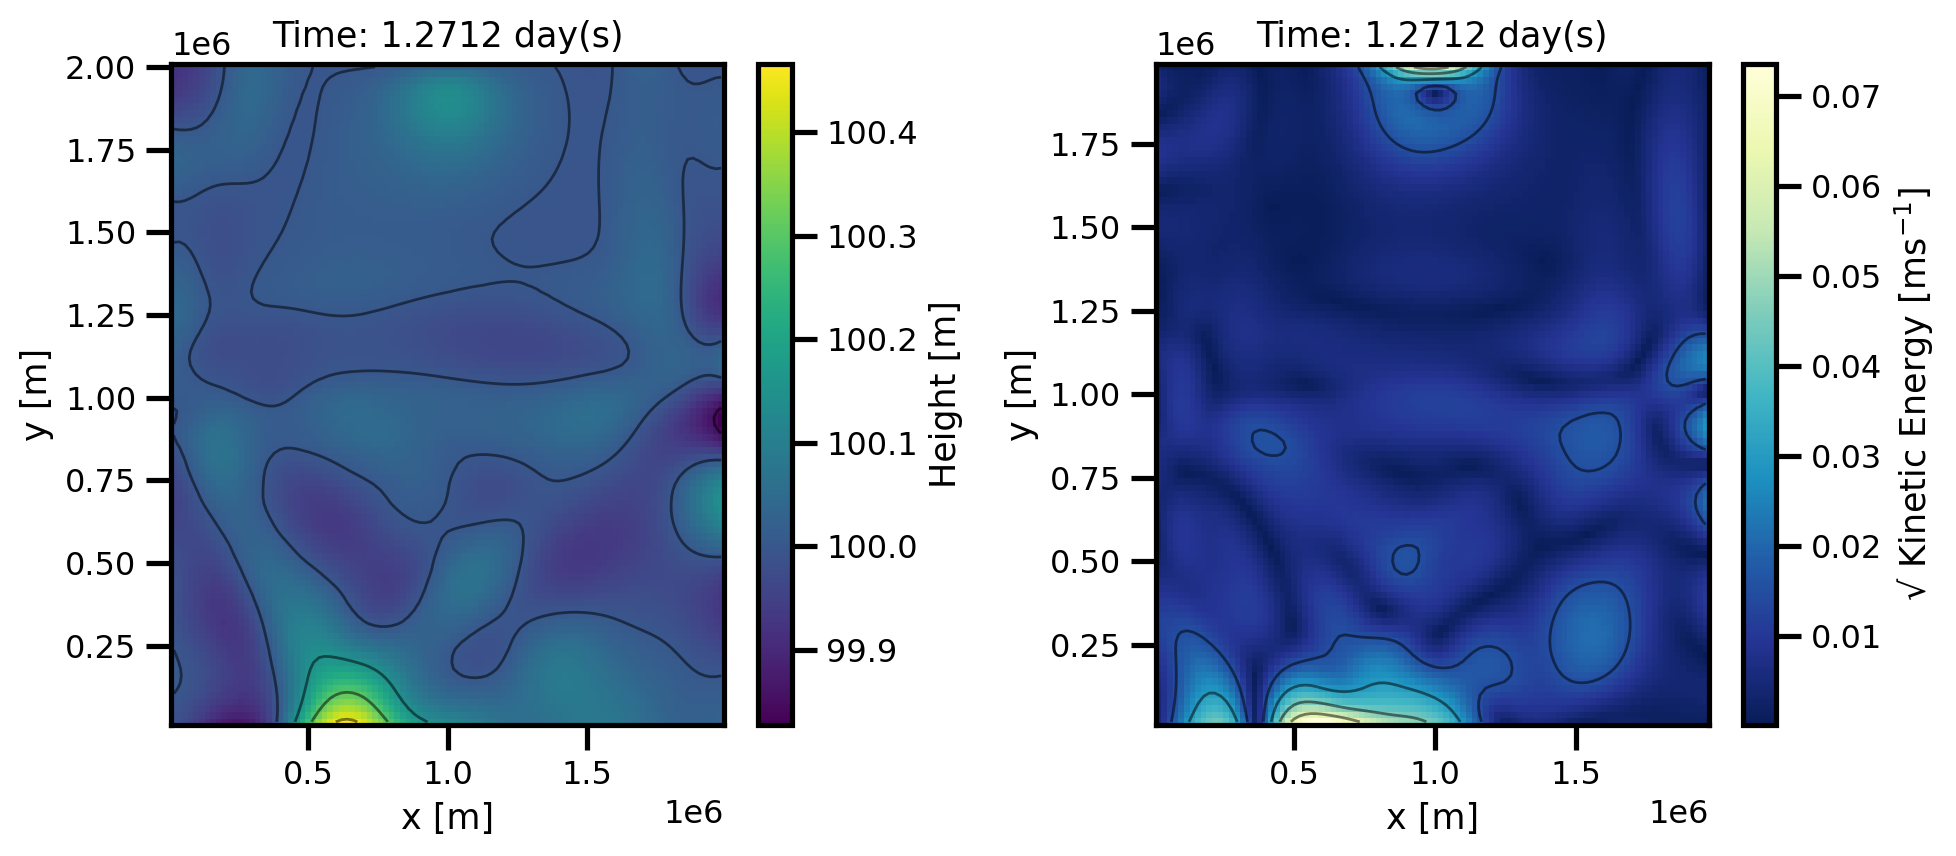

In [27]:
%matplotlib inline
mov = Movie(
    ds_results.transpose("time", "y", "x"),
    plotfunc=custom_plot_h_ke_layers,
    framedim="time",
    input_check=False,
)
mov.preview(15)

In [28]:
create_movie(
    ds_results.transpose(
        "time", "y", "x"
    ),  # .sel(time=slice("2017-02-01", "2017-03-01")),
    name="swe_linear",
    plotfunc=custom_plot_h_ke_layers,
    file_path="./",
    framedim="time",
    cmap="viridis",
    robust=True,
)

  0%|          | 0/60 [00:00<?, ?it/s]

No ffmpeg found


/bin/sh: ffmpeg: command not found


RuntimeError: Could not find an ffmpeg version on the system.         Please install ffmpeg with e.g. `conda install -c conda-forge ffmpeg`